<h2>1. Crawl the list of Toronto neighborhoods</h2>

In [1]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd

Crawl the URL and parse the HTML doc

In [2]:
res = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
soup = BeautifulSoup(res.content, 'html.parser')

In [3]:
data = []
table = soup.find('table', attrs={'class':'wikitable'})
table_body = table.find('tbody')

rows = table_body.find_all('tr')
for row in rows:
    cols = row.find_all('td')
    if len(cols) > 0:
        cols = [ele.text.strip() for ele in [x for x in cols if x != None and len(x) > 0]] # Get rid of the first fow which contains table header
        data.append([ele for ele in cols if ele])  

Generate the dataframe

In [4]:
df = pd.DataFrame(data)
df.columns = ['postal_code', 'borough', 'neighborhood']
df.head()

,postal_code,borough,neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


Filter out the "Not assigned" boroughs

In [5]:
df_2 = df[df.borough != 'Not assigned']

Replace "Not assigned" neighborhoods using their boroughs

In [6]:
df_2.loc[df_2.neighborhood == 'Not assigned','neighborhood'] = df_2['borough']

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Check the data after cleaning

In [7]:
df_2.head()

,postal_code,borough,neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


In [8]:
print('check the number of rows before and after data cleaning')
print('before cleaning: {} rows'.format(len(df)))
print('after cleaning: {} rows'.format(len(df_2)))

check the number of rows before and after data cleaning
before cleaning: 288 rows
after cleaning: 211 rows


In [10]:
df_2[df_2.postal_code == 'M5A'].head()

,postal_code,borough,neighborhood
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park


In [29]:
df_group_neighborhood = pd.DataFrame(df_2.groupby(['postal_code', 'borough'])['neighborhood'].apply(lambda x: ','.join(x))).reset_index()

In [12]:
df_group_neighborhood.head()

,postal_code,borough,neighborhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


<h2>2. Merging the location lat/long to the neighborhoods</h2>

In [1]:
!pip install geocoder

    100% |████████████████████████████████| 102kB 17.2MB/s a 0:00:01
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.


Download the geospatial data because geocoder cannot return the lat long

In [13]:
url = 'https://cocl.us/Geospatial_data'
r = requests.get(url, allow_redirects=True)
open('Geospatial_Coordinates.csv', 'wb').write(r.content)

2891

In [15]:
df_geo = pd.read_csv('Geospatial_Coordinates.csv')
df_geo.columns = ['postal_code', 'lat', 'lon']

In [16]:
df_geo.head()

,postal_code,lat,lon
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Join the geospatial data to the neighborhood dataframe

In [34]:
df_group_neighborhood_latlon = df_group_neighborhood.merge(df_geo, on='postal_code', how='inner').reset_index()

In [35]:
df_group_neighborhood_latlon.head()

,index,postal_code,borough,neighborhood,lat,lon
0,0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


<h2>3. Perform the neighborhood analysis</h2>

Only consider neighborhood whose name contains Toronto

In [36]:
df_group_neighborhood_toronto = df_group_neighborhood_latlon[df_group_neighborhood_latlon.borough.str.contains('Toronto')]

In [37]:
df_group_neighborhood_toronto.head(10)

,index,postal_code,borough,neighborhood,lat,lon
37,37,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,41,M4K,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188
42,42,M4L,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572
43,43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
45,45,M4P,Central Toronto,Davisville North,43.712751,-79.390197
46,46,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
47,47,M4S,Central Toronto,Davisville,43.704324,-79.388790
48,48,M4T,Central Toronto,"Moore Park,Summerhill East",43.689574,-79.383160
49,49,M4V,Central Toronto,"Deer Park,Forest Hill SE,Rathnelly,South Hill,...",43.686412,-79.400049


Set up the params and functions need to access Foursquare to get venues of Toronto neighborhoods

In [38]:
CLIENT_ID = 'TKEQXHQEP0PMJGEWMD5HOHWXUV1BKE1RP5I0325UKYQ2HHF0' # your Foursquare ID
CLIENT_SECRET = 'QYZ1UD1UYYXMZPNM1RDG5C4YFG4AN33QQEBIQRCSAABD0GGO' # your Foursquare Secret
VERSION = '20190520' # Foursquare API version
LIMIT = 100

In [39]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Get the venues

In [40]:
toronto_venues = getNearbyVenues(names=df_group_neighborhood_toronto['neighborhood'], latitudes=df_group_neighborhood_toronto['lat'], longitudes=df_group_neighborhood_toronto['lon'])

The Beaches
The Danforth West,Riverdale
The Beaches West,India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park,Summerhill East
Deer Park,Forest Hill SE,Rathnelly,South Hill,Summerhill West
Rosedale
Cabbagetown,St. James Town
Church and Wellesley
Harbourfront,Regent Park
Ryerson,Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide,King,Richmond
Harbourfront East,Toronto Islands,Union Station
Design Exchange,Toronto Dominion Centre
Commerce Court,Victoria Hotel
Roselawn
Forest Hill North,Forest Hill West
The Annex,North Midtown,Yorkville
Harbord,University of Toronto
Chinatown,Grange Park,Kensington Market
CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place,Underground city
Christie
Dovercourt Village,Dufferin
Little Portugal,Trinity
Brockton,Exhibition Place,Parkdale Village
High Park,The Junction South
Parkdale,Roncesvall

In [41]:
print(toronto_venues.shape)
toronto_venues.head()

(1695, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
1,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
2,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
3,The Beaches,43.676357,-79.293031,Dip 'n Sip,43.678897,-79.297745,Coffee Shop
4,"The Danforth West,Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant


Count the number of venues per neighborhoods

In [43]:
toronto_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide,King,Richmond",100,100,100,100,100,100
Berczy Park,56,56,56,56,56,56
"Brockton,Exhibition Place,Parkdale Village",22,22,22,22,22,22
Business Reply Mail Processing Centre 969 Eastern,18,18,18,18,18,18
"CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara",14,14,14,14,14,14


In [61]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 239 uniques categories.


One-hot encoding the number of venues, per venue categoriy, per neighborhood. They will be "features" to perform clustering

In [45]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot.head()

,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 
toronto_onehot.head()

,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide,King,Richmond",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,...,0.000000,0.00000,0.00,0.010000,0.000000,0.000000,0.010000,0.000000,0.00,0.000000
1,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.00,0.017857,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
2,"Brockton,Exhibition Place,Parkdale Village",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
3,Business Reply Mail Processing Centre 969 Eastern,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.055556
4,"CN Tower,Bathurst Quay,Island airport,Harbourf...",0.000000,0.000000,0.071429,0.071429,0.071429,0.142857,0.214286,0.142857,0.000000,...,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
5,"Cabbagetown,St. James Town",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
6,Central Bay Street,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011494,...,0.000000,0.00000,0.00,0.011494,0.000000,0.000000,0.011494,0.000000,0.00,0.011494
7,"Chinatown,Grange Park,Kensington Market",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.010000,0.00000,0.00,0.060000,0.000000,0.030000,0.010000,0.000000,0.00,0.000000
8,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
9,Church and Wellesley,0.011494,0.011494,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011494,...,0.000000,0.00000,0.00,0.000000,0.011494,0.011494,0.000000,0.011494,0.00,0.011494


Get the top 5 venue categories for each neighborhood

In [200]:
tmp = pd.DataFrame((toronto_grouped == 0.0).sum())
mostly_zero_cols = tmp[tmp[0]>= (len(toronto_grouped) * 0.5)].index.tolist()
mostly_zero_cols


['Adult Boutique',
 'Afghan Restaurant',
 'Airport',
 'Airport Food Court',
 'Airport Gate',
 'Airport Lounge',
 'Airport Service',
 'Airport Terminal',
 'American Restaurant',
 'Antique Shop',
 'Aquarium',
 'Art Gallery',
 'Art Museum',
 'Arts & Crafts Store',
 'Asian Restaurant',
 'Athletics & Sports',
 'Auto Workshop',
 'BBQ Joint',
 'Baby Store',
 'Bagel Shop',
 'Bank',
 'Bar',
 'Baseball Stadium',
 'Basketball Stadium',
 'Beach',
 'Bed & Breakfast',
 'Beer Bar',
 'Beer Store',
 'Belgian Restaurant',
 'Bistro',
 'Board Shop',
 'Boat or Ferry',
 'Bookstore',
 'Boutique',
 'Brazilian Restaurant',
 'Breakfast Spot',
 'Brewery',
 'Bubble Tea Shop',
 'Burger Joint',
 'Burrito Place',
 'Bus Line',
 'Business Service',
 'Butcher',
 'Cajun / Creole Restaurant',
 'Camera Store',
 'Caribbean Restaurant',
 'Cheese Shop',
 'Chinese Restaurant',
 'Chocolate Shop',
 'Church',
 'Climbing Gym',
 'Clothing Store',
 'Cocktail Bar',
 'College Arts Building',
 'College Gym',
 'College Rec Center',
 'C

In [49]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide,King,Richmond----
                 venue  freq
0          Coffee Shop  0.06
1                 Café  0.05
2           Steakhouse  0.04
3  American Restaurant  0.04
4                  Bar  0.04


----Berczy Park----
                venue  freq
0         Coffee Shop  0.09
1        Cocktail Bar  0.05
2  Italian Restaurant  0.04
3  Seafood Restaurant  0.04
4            Beer Bar  0.04


----Brockton,Exhibition Place,Parkdale Village----
                   venue  freq
0                   Café  0.09
1         Breakfast Spot  0.09
2            Coffee Shop  0.09
3  Performing Arts Venue  0.09
4          Burrito Place  0.05


----Business Reply Mail Processing Centre 969 Eastern----
                venue  freq
0         Yoga Studio  0.06
1                 Spa  0.06
2  Light Rail Station  0.06
3       Garden Center  0.06
4              Garden  0.06


----CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara----
              venue  freq
0

Generate top 10 most frequent venue categories in each neighborhood. This data will serve to analyze the clusters' characteristics

In [50]:
def return_most_common_venues(row, num_top_venues):    
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [51]:
import numpy as np

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide,King,Richmond",Coffee Shop,Café,Thai Restaurant,Bar,American Restaurant,Steakhouse,Cosmetics Shop,Bakery,Burger Joint,Hotel
1,Berczy Park,Coffee Shop,Cocktail Bar,Cheese Shop,Beer Bar,Bakery,Steakhouse,Italian Restaurant,Seafood Restaurant,Farmers Market,Café
2,"Brockton,Exhibition Place,Parkdale Village",Performing Arts Venue,Coffee Shop,Café,Breakfast Spot,Gym,Italian Restaurant,Pet Store,Gym / Fitness Center,Climbing Gym,Caribbean Restaurant
3,Business Reply Mail Processing Centre 969 Eastern,Yoga Studio,Recording Studio,Smoke Shop,Skate Park,Brewery,Burrito Place,Butcher,Restaurant,Park,Auto Workshop
4,"CN Tower,Bathurst Quay,Island airport,Harbourf...",Airport Service,Airport Lounge,Airport Terminal,Harbor / Marina,Boat or Ferry,Sculpture Garden,Boutique,Airport Gate,Airport,Airport Food Court


<h2>4. Clustering the neighborhoods</h2>

Perform the clustering, with kMean

In [201]:
from sklearn.cluster import KMeans


# set number of clusters
kclusters = 1

toronto_grouped_clustering = toronto_grouped.drop(columns=['Neighborhood'])
features_cols = [x for x in toronto_grouped_clustering.columns if x not in mostly_zero_cols]

# run k-means clustering
results = []
for kclusters in range(1, 15):
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering[features_cols])
    results.append((kclusters, kmeans.inertia_))

   
    
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([ 1,  1,  7,  0, 10,  1,  9, 12,  3,  1], dtype=int32)

<function matplotlib.pyplot.show>

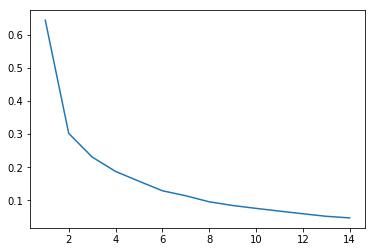

In [202]:
import matplotlib.pyplot as plt

res_pd = pd.DataFrame(results)
res_pd.columns = ['k', 'inert']

plt.plot(res_pd['k'], res_pd['inert'])

plt.show

Using the knee method, we should select the k as 8

In [225]:
klusters = 6
kmeans = KMeans(n_clusters=klusters, random_state=0).fit(toronto_grouped_clustering[features_cols])

In [218]:
# add clustering labels
neighborhoods_venues_sorted['cluster_label'] = kmeans.labels_

In [219]:
try:
    neighborhoods_venues_sorted = neighborhoods_venues_sorted.rename(columns={'Neighborhood':'neighborhood'})
except:
    print('')
neighborhoods_venues_sorted.head()

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,cluster_label
0,"Adelaide,King,Richmond",Coffee Shop,Café,Thai Restaurant,Bar,American Restaurant,Steakhouse,Cosmetics Shop,Bakery,Burger Joint,Hotel,5
1,Berczy Park,Coffee Shop,Cocktail Bar,Cheese Shop,Beer Bar,Bakery,Steakhouse,Italian Restaurant,Seafood Restaurant,Farmers Market,Café,5
2,"Brockton,Exhibition Place,Parkdale Village",Performing Arts Venue,Coffee Shop,Café,Breakfast Spot,Gym,Italian Restaurant,Pet Store,Gym / Fitness Center,Climbing Gym,Caribbean Restaurant,5
3,Business Reply Mail Processing Centre 969 Eastern,Yoga Studio,Recording Studio,Smoke Shop,Skate Park,Brewery,Burrito Place,Butcher,Restaurant,Park,Auto Workshop,0
4,"CN Tower,Bathurst Quay,Island airport,Harbourf...",Airport Service,Airport Lounge,Airport Terminal,Harbor / Marina,Boat or Ferry,Sculpture Garden,Boutique,Airport Gate,Airport,Airport Food Court,0


Merge with the neighborhood lat/lon and borough

In [220]:
df_final = df_group_neighborhood_toronto.merge(neighborhoods_venues_sorted, on='neighborhood', how='inner').reset_index()

In [221]:
df_final.head()

,level_0,index,postal_code,borough,neighborhood,lat,lon,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,cluster_label
0,0,37,M4E,East Toronto,The Beaches,43.676357,-79.293031,Health Food Store,Coffee Shop,Pub,Dessert Shop,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,2
1,1,41,M4K,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188,Greek Restaurant,Coffee Shop,Ice Cream Shop,Italian Restaurant,Furniture / Home Store,Pizza Place,Brewery,Bubble Tea Shop,Café,Restaurant,5
2,2,42,M4L,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572,Sandwich Place,Board Shop,Pub,Burger Joint,Liquor Store,Burrito Place,Light Rail Station,Fast Food Restaurant,Fish & Chips Shop,Steakhouse,0
3,3,43,M4M,East Toronto,Studio District,43.659526,-79.340923,Café,Coffee Shop,Gastropub,Bakery,American Restaurant,Italian Restaurant,Music Store,Seafood Restaurant,Convenience Store,Stationery Store,3
4,4,44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,Park,Swim School,Bus Line,Yoga Studio,Diner,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,4


In [222]:
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab

Display the neighborhoods on the map, to see if there are any kinds of geospatial relationship between clusters

In [223]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
start_lat = df_final.iloc[0,:]['lat']
start_lon = df_final.iloc[0,:]['lon']

map_clusters = folium.Map(location=[start_lat, start_lon], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_final['lat'], df_final['lon'], df_final['neighborhood'], df_final['cluster_label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [168]:
df_final.groupby('cluster_label')['postal_code'].count()

cluster_label
0     2
1    29
2     3
3     3
4     1
Name: postal_code, dtype: int64

Even when the k is big, almost all the neighborhoods belong to one cluster. Maybe the dimension is too large, and we have a very few of data points
We may need to limit the dimension to several high frequency venue categories

In [171]:
len(features_cols)

82

Run the kMean again (previous note graph)

In [230]:
for i in range(0, klusters):
    print('Cluster number : {}'.format(i))
    display((df_final[df_final.cluster_label == i]))

Cluster number : 0


,level_0,index,postal_code,borough,neighborhood,lat,lon,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,cluster_label
2,2,42,M4L,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572,Sandwich Place,Board Shop,Pub,Burger Joint,Liquor Store,Burrito Place,Light Rail Station,Fast Food Restaurant,Fish & Chips Shop,Steakhouse,0
5,5,45,M4P,Central Toronto,Davisville North,43.712751,-79.390197,Hotel,Food & Drink Shop,Gym,Sandwich Place,Park,Breakfast Spot,Asian Restaurant,Clothing Store,Dog Run,Doner Restaurant,0
8,8,48,M4T,Central Toronto,"Moore Park,Summerhill East",43.689574,-79.383160,Gym,Tennis Court,Yoga Studio,Dessert Shop,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,0
22,22,63,M5N,Central Toronto,Roselawn,43.711695,-79.416936,Garden,Home Service,Yoga Studio,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,0
27,27,68,M5V,Downtown Toronto,"CN Tower,Bathurst Quay,Island airport,Harbourf...",43.628947,-79.394420,Airport Service,Airport Lounge,Airport Terminal,Harbor / Marina,Boat or Ferry,Sculpture Garden,Boutique,Airport Gate,Airport,Airport Food Court,0
31,31,76,M6H,West Toronto,"Dovercourt Village,Dufferin",43.669005,-79.442259,Bakery,Pharmacy,Supermarket,Gym / Fitness Center,Pool,Music Venue,Discount Store,Middle Eastern Restaurant,Café,Brewery,0
37,37,87,M7Y,East Toronto,Business Reply Mail Processing Centre 969 Eastern,43.662744,-79.321558,Yoga Studio,Recording Studio,Smoke Shop,Skate Park,Brewery,Burrito Place,Butcher,Restaurant,Park,Auto Workshop,0


Cluster number : 1


,level_0,index,postal_code,borough,neighborhood,lat,lon,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,cluster_label
10,10,50,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,Park,Playground,Trail,Department Store,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,1


Cluster number : 2


,level_0,index,postal_code,borough,neighborhood,lat,lon,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,cluster_label
0,0,37,M4E,East Toronto,The Beaches,43.676357,-79.293031,Health Food Store,Coffee Shop,Pub,Dessert Shop,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,2
9,9,49,M4V,Central Toronto,"Deer Park,Forest Hill SE,Rathnelly,South Hill,...",43.686412,-79.400049,Coffee Shop,Pub,Pizza Place,American Restaurant,Light Rail Station,Sports Bar,Supermarket,Sushi Restaurant,Bagel Shop,Fried Chicken Joint,2
13,13,53,M5A,Downtown Toronto,"Harbourfront,Regent Park",43.654260,-79.360636,Coffee Shop,Pub,Bakery,Park,Mexican Restaurant,Breakfast Spot,Café,Theater,Gym / Fitness Center,Historic Site,2
17,17,57,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,Coffee Shop,Café,Chinese Restaurant,Italian Restaurant,Burger Joint,Sushi Restaurant,Sandwich Place,Bakery,Middle Eastern Restaurant,Bar,2


Cluster number : 3


,level_0,index,postal_code,borough,neighborhood,lat,lon,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,cluster_label
3,3,43,M4M,East Toronto,Studio District,43.659526,-79.340923,Café,Coffee Shop,Gastropub,Bakery,American Restaurant,Italian Restaurant,Music Store,Seafood Restaurant,Convenience Store,Stationery Store,3
25,25,66,M5S,Downtown Toronto,"Harbord,University of Toronto",43.662696,-79.400049,Café,Italian Restaurant,Bookstore,Restaurant,Bakery,Japanese Restaurant,Bar,Nightclub,Dessert Shop,Sushi Restaurant,3
30,30,75,M6G,Downtown Toronto,Christie,43.669542,-79.422564,Grocery Store,Café,Park,Athletics & Sports,Diner,Italian Restaurant,Restaurant,Nightclub,Baby Store,Coffee Shop,3
34,34,82,M6P,West Toronto,"High Park,The Junction South",43.661608,-79.464763,Mexican Restaurant,Café,Bar,Flea Market,Arts & Crafts Store,Fast Food Restaurant,Bookstore,Park,Speakeasy,Cajun / Creole Restaurant,3


Cluster number : 4


,level_0,index,postal_code,borough,neighborhood,lat,lon,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,cluster_label
4,4,44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,Park,Swim School,Bus Line,Yoga Studio,Diner,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,4
23,23,64,M5P,Central Toronto,"Forest Hill North,Forest Hill West",43.696948,-79.411307,Trail,Park,Jewelry Store,Sushi Restaurant,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Yoga Studio,4


Cluster number : 5


,level_0,index,postal_code,borough,neighborhood,lat,lon,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,cluster_label
1,1,41,M4K,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188,Greek Restaurant,Coffee Shop,Ice Cream Shop,Italian Restaurant,Furniture / Home Store,Pizza Place,Brewery,Bubble Tea Shop,Café,Restaurant,5
6,6,46,M4R,Central Toronto,North Toronto West,43.715383,-79.405678,Coffee Shop,Clothing Store,Yoga Studio,Sporting Goods Shop,Gym / Fitness Center,Cosmetics Shop,Chinese Restaurant,Rental Car Location,Dessert Shop,Salon / Barbershop,5
7,7,47,M4S,Central Toronto,Davisville,43.704324,-79.388790,Sandwich Place,Dessert Shop,Italian Restaurant,Café,Sushi Restaurant,Coffee Shop,Pharmacy,Pizza Place,Thai Restaurant,Gourmet Shop,5
11,11,51,M4X,Downtown Toronto,"Cabbagetown,St. James Town",43.667967,-79.367675,Coffee Shop,Italian Restaurant,Restaurant,Café,Pub,Park,Bakery,Pizza Place,Pet Store,Beer Store,5
12,12,52,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Gay Bar,Restaurant,Gym,Men's Store,Bubble Tea Shop,Burger Joint,Café,5
14,14,54,M5B,Downtown Toronto,"Ryerson,Garden District",43.657162,-79.378937,Coffee Shop,Clothing Store,Café,Cosmetics Shop,Middle Eastern Restaurant,Bubble Tea Shop,Pizza Place,Sporting Goods Shop,Italian Restaurant,Japanese Restaurant,5
15,15,55,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,Coffee Shop,Café,Hotel,Restaurant,Cosmetics Shop,Gastropub,Clothing Store,Bakery,Breakfast Spot,Japanese Restaurant,5
16,16,56,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,Coffee Shop,Cocktail Bar,Cheese Shop,Beer Bar,Bakery,Steakhouse,Italian Restaurant,Seafood Restaurant,Farmers Market,Café,5
18,18,58,M5H,Downtown Toronto,"Adelaide,King,Richmond",43.650571,-79.384568,Coffee Shop,Café,Thai Restaurant,Bar,American Restaurant,Steakhouse,Cosmetics Shop,Bakery,Burger Joint,Hotel,5
19,19,59,M5J,Downtown Toronto,"Harbourfront East,Toronto Islands,Union Station",43.640816,-79.381752,Coffee Shop,Hotel,Aquarium,Café,Italian Restaurant,Scenic Lookout,Bakery,Restaurant,Brewery,Pizza Place,5
